In [1]:
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchinfo import summary
from captum.attr import DeepLift
import pickle
torch.manual_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # For M1 chip, torch.device("mps") is used instead of torch.device("cuda")

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading and transforming the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img1 = transform(Image.open("datasets/my_dataset/1.jpg")).unsqueeze(0)
img2 = transform(Image.open("datasets/my_dataset/2.jpg")).unsqueeze(0)
img3 = transform(Image.open("datasets/my_dataset/3.jpg")).unsqueeze(0)
img4 = transform(Image.open("datasets/my_dataset/4.jpg")).unsqueeze(0)
img5 = transform(Image.open("datasets/my_dataset/5.jpg")).unsqueeze(0)
image_data = {
    'image_0': {
        'image': img1,
        'label': torch.tensor([1]),  # Replace with actual label index
        'label_human': ['goldfish','Carassius auratus'],  # Replace with actual human-readable label
    },

    'image_1': {
        'image': img2,
        'label': torch.tensor([94]),  # Replace with actual label index
        'label_human': ['hummingbird'],  # Replace with actual human-readable label
    },

    'image_2': {
        'image': img3,
        'label': torch.tensor([100]),  # Replace with actual label index
        'label_human': ['black swan', 'Cygnus atratus'],  # Replace with actual human-readable label
    },

    'image_3': {
        'image': img4,
        'label': torch.tensor([207]),  # Replace with actual label index
        'label_human': ['golden retriever'],  # Replace with actual human-readable label
    },

    'image_4': {
        'image': img5,
        'label': torch.tensor([985]),  # Replace with actual label index
        'label_human': ['daisy'],  # Replace with actual human-readable label
    }

}

image_data

{'image_0': {'image': tensor([[[[-2.0323, -2.0323, -2.0323,  ..., -1.0390, -0.9705, -0.9192],
            [-2.0323, -2.0323, -2.0323,  ..., -1.0219, -0.9534, -0.9020],
            [-2.0323, -2.0323, -2.0323,  ..., -0.9705, -0.9534, -0.9534],
            ...,
            [ 1.9064,  1.8722,  1.9578,  ...,  1.2214,  1.1015,  0.9988],
            [ 1.6667,  1.5810,  1.8037,  ...,  1.1700,  1.0331,  0.9817],
            [ 1.3242,  1.1529,  1.3584,  ...,  1.1015,  1.0502,  1.1015]],
  
           [[-1.9307, -1.9307, -1.9307,  ..., -0.5651, -0.5301, -0.4951],
            [-1.9307, -1.9307, -1.9307,  ..., -0.7752, -0.7227, -0.6702],
            [-1.9307, -1.9307, -1.9307,  ..., -0.9328, -0.8978, -0.8803],
            ...,
            [ 1.9734,  2.0084,  2.0784,  ...,  0.9580,  0.9230,  0.8179],
            [ 1.7458,  1.7808,  1.9734,  ...,  0.8880,  0.8529,  0.7829],
            [ 1.4832,  1.4132,  1.6408,  ...,  0.8179,  0.7479,  0.7829]],
  
           [[-1.7870, -1.7870, -1.7870,  ..., -1.5

In [3]:
def explainer(model, labels_human, DEVICE):
    model.to(DEVICE)
    model.eval()

    # Explainer 
    attribution = DeepLift(model)

    # # Load images and labels
    # with open("sample_imagenetdata", 'rb') as f:
    #     image_data = pickle.load(f)
    fig, ax = plt.subplots(5,3, figsize=(30,50))
    i=0
    for key,value in image_data.items():
        X = value['image']
        y = value['label']
        label = value['label_human']
        X, y = X.to(DEVICE), y.to(DEVICE)
        # Predict the label
        output = model(X)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_label = torch.max(probabilities, 0)[1].item()

        # Compute the attribution scores using Saliency for true label
        attr_true = attribution.attribute(inputs=X, target=y)

        # Compute the attribution scores using Saliency for predicted label
        attr_pred = attribution.attribute(inputs=X, target=predicted_label)

        # Transform the image to original scale
        X = X * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        
        # Visualize the attribution scores for true label
        explainer_true, _ = torch.max(attr_true.data.abs(), dim=1) 
        explainer_true = explainer_true.cpu().detach().numpy()
        explainer_true = (explainer_true-explainer_true.min())/(explainer_true.max()-explainer_true.min())

        # Visualize the attribution scores for predicted label
        explainer_pred, _ = torch.max(attr_pred.data.abs(), dim=1)
        explainer_pred = explainer_pred.cpu().detach().numpy()
        explainer_pred = (explainer_pred-explainer_pred.min())/(explainer_pred.max()-explainer_pred.min())
        ax[i][0].imshow(X[0].permute(1, 2, 0).to('cpu'))
        ax[i][1].imshow(explainer_true[0])
        ax[i][1].set_title(f"True: {label[0]}", fontsize=48)
        ax[i][2].imshow(explainer_pred[0])
        ax[i][2].set_title(f"Predicted: {labels_human[predicted_label][0]}", fontsize=48)
        ax[i][0].set_xticks([])
        ax[i][0].set_yticks([])
        ax[i][1].set_xticks([])
        ax[i][1].set_yticks([])
        ax[i][2].set_xticks([])
        ax[i][2].set_yticks([])
        i+=1
    fig.subplots_adjust(wspace=0, hspace=0, top=1.0)
    plt.savefig("Deeplift.png", bbox_inches='tight')

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [1, 3, 224, 224]     [1, 1000]            --                   True
├─BasicConv2d (conv1)                    [1, 3, 224, 224]     [1, 64, 112, 112]    --                   True
│    └─Conv2d (conv)                     [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (bn)                  [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─MaxPool2d (maxpool1)                   [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─BasicConv2d (conv2)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    └─Conv2d (conv)                     [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    └─BatchNorm2d (bn)                  [1, 64, 56, 56]      [1, 64, 56, 56]      128                  True
├─BasicConv2d (c

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


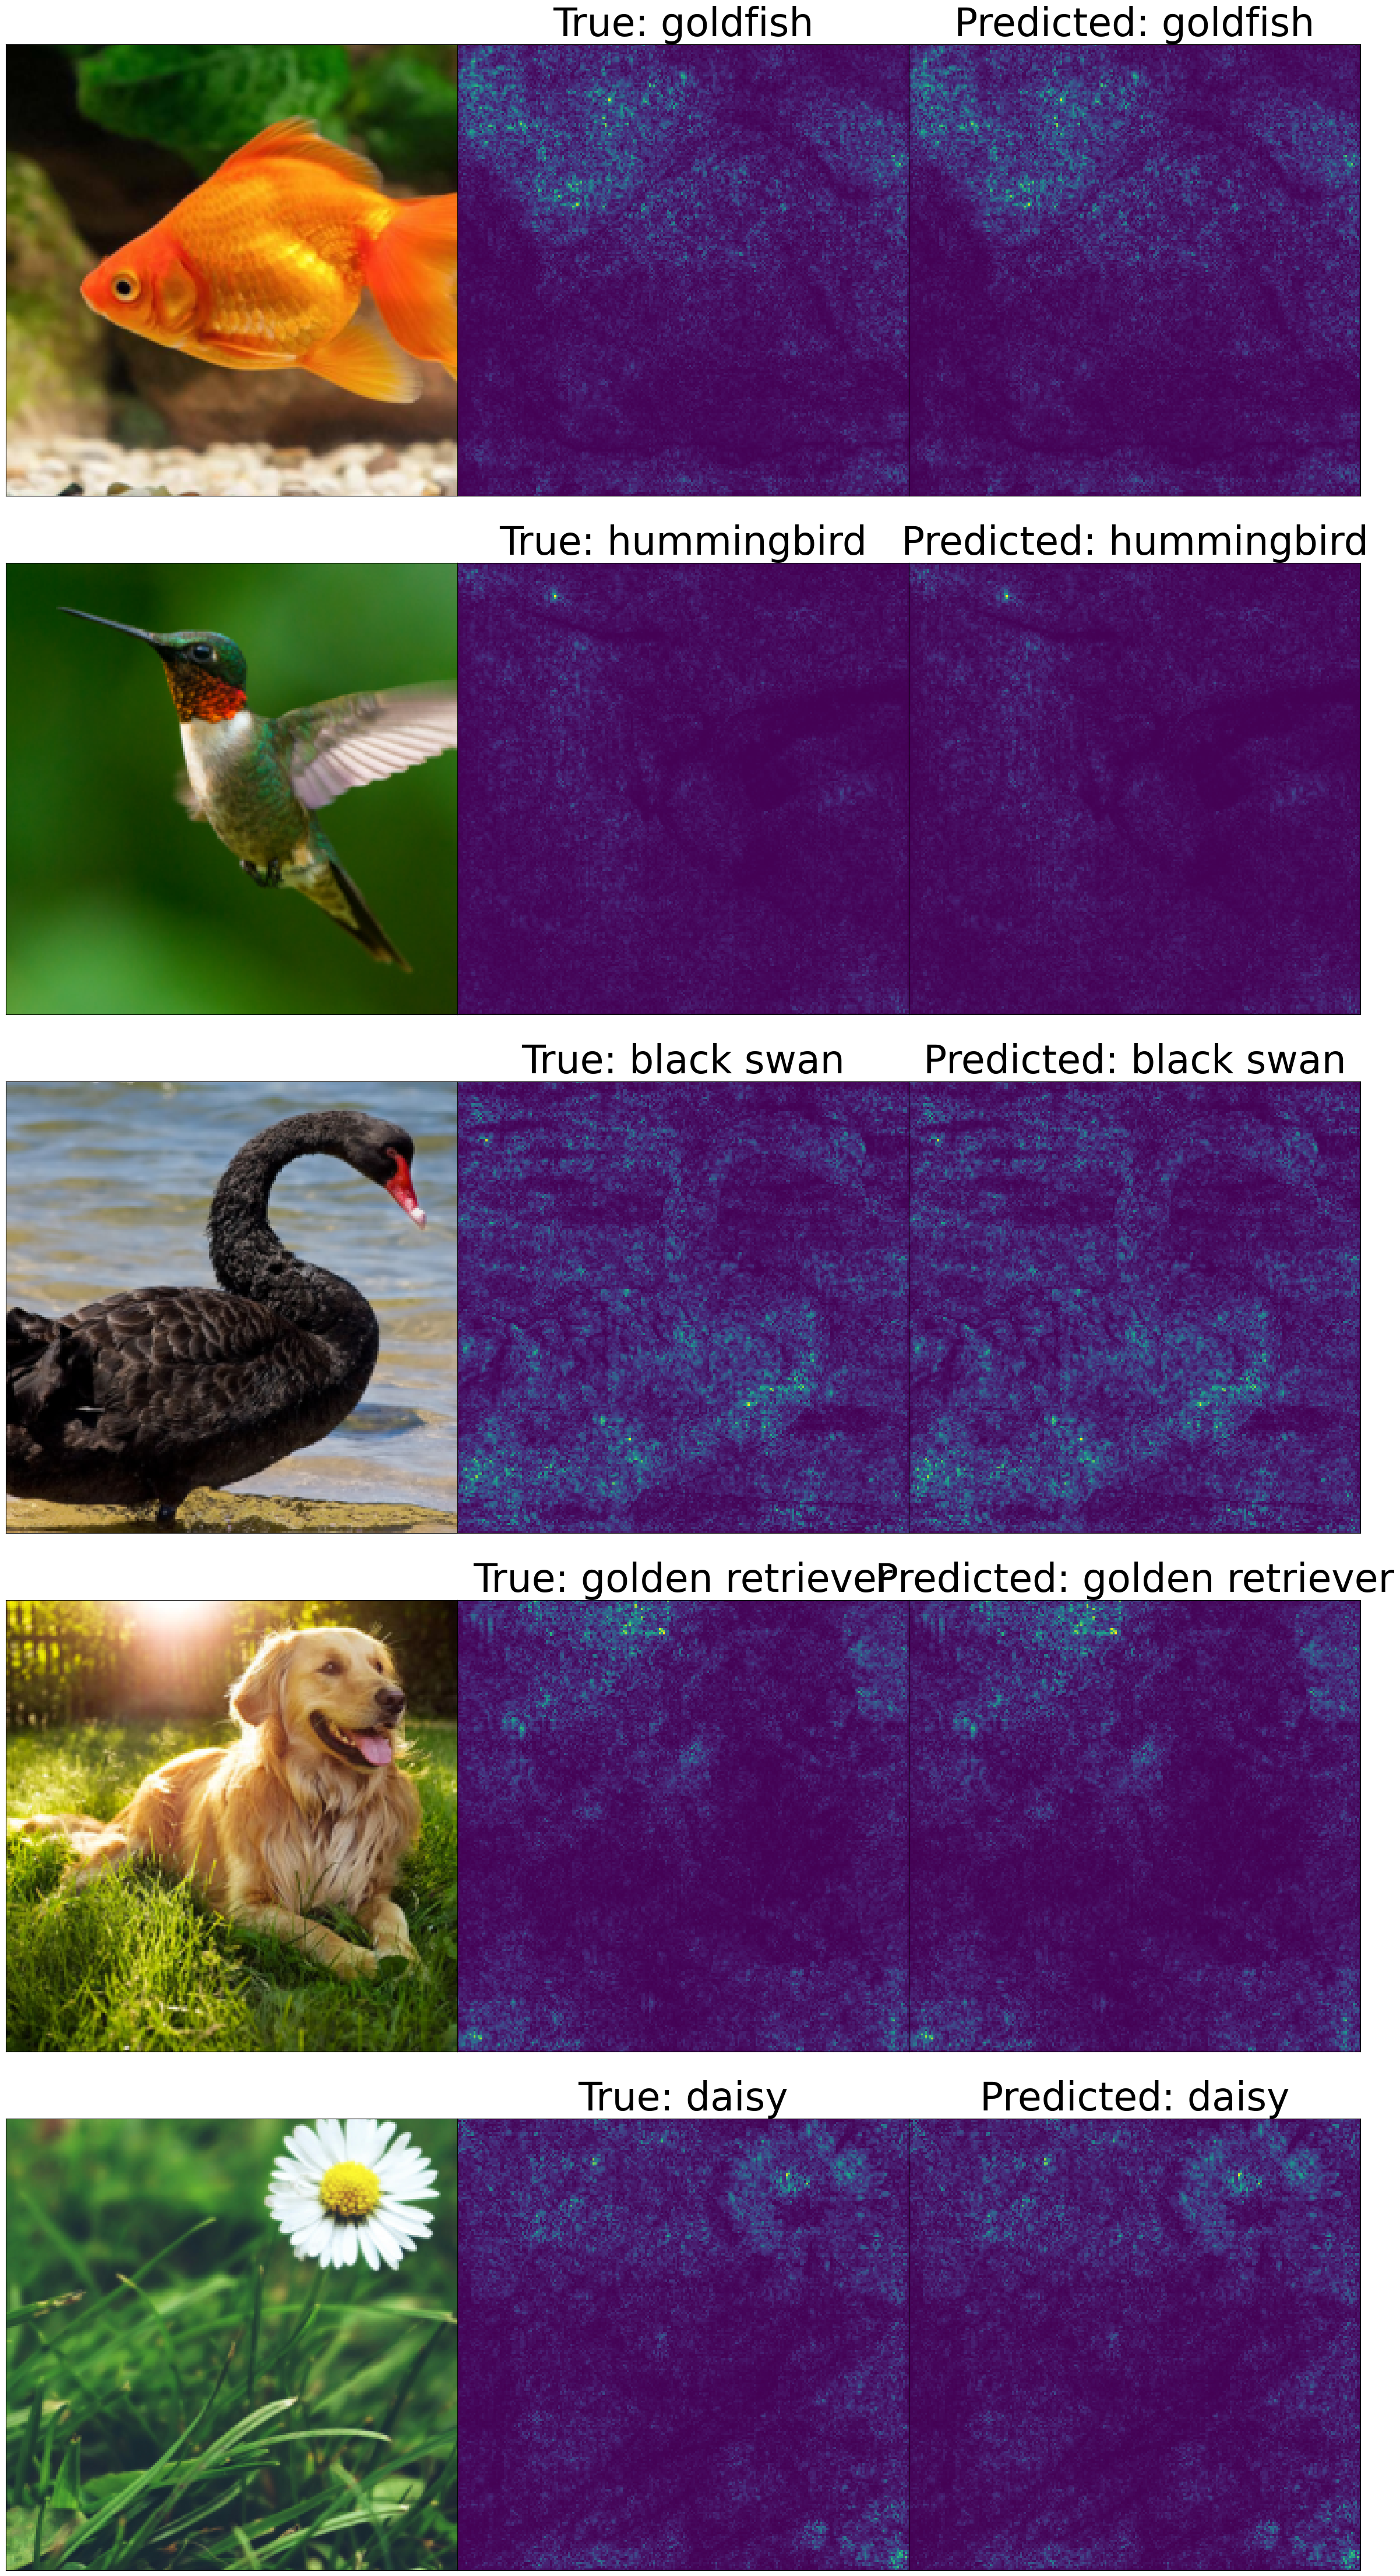

In [4]:
if __name__=="__main__":

    # Create the model
    model_googlenet= models.googlenet(pretrained=True)

    # Summary of the model
    print(summary(model=model_googlenet, input_size=(1, 3, 224, 224), col_width=20, col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0))
    
    # Load classes to human readable labels
    labels_human = {}
    with open(f'imagenet1000_clsidx_to_labels.txt') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip().replace("'", "").strip(",")
            if "{" in line or "}" in line:
                continue
            else:
                idx = int(line.split(":")[0])
                lbl = line.split(":")[1].split(",")
                labels_human[idx] = [x.strip() for x in lbl]
    # Explainer
    explainer(model_googlenet, labels_human,  DEVICE)